In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
from sklearn.cluster import KMeans
import numpy as np
pd.set_option('display.width', 2000)

In [2]:
nucleus_df = pd.read_csv('csv/nuclei_cd86_2.csv')
image_df = pd.read_csv('csv\images_cd86_2.csv')

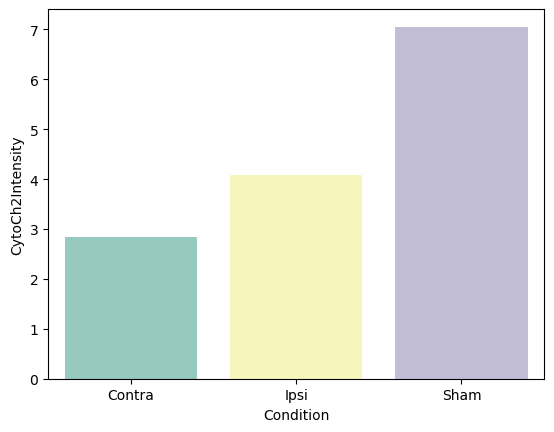

In [3]:

#nucleus_df = nucleus_df[nucleus_df['Location'] == 'DG']
mean_intensity = nucleus_df.groupby('Condition')['CytoCh2Intensity'].mean().reset_index()

#grouped_df=merged_df.groupby('ImageName')

# Plotting
sns.barplot(data=mean_intensity, x='Condition', y='CytoCh2Intensity', palette='Set3')
plt.show()

In [4]:
import napari
all_sorted_clusters = []
for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    list = df['CytoCh2Intensity']
    intensity_values_reshaped = np.array(list).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(intensity_values_reshaped)
    sorted_clusters = np.argsort(kmeans.cluster_centers_.flatten())
    all_sorted_clusters.append(sorted_clusters)



common_ordering = np.argsort(np.mean(all_sorted_clusters, axis=0))

# Assign consistent cluster labels based on the common ordering
consistent_labels = {common_ordering[0]: 0, common_ordering[1]: 1}

nucleus_df['Cluster_Label'] = np.nan
for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    intensity_values = df['CytoCh2Intensity'].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto", init=kmeans.cluster_centers_[common_ordering].reshape(-1, 1))
    clusters = kmeans.fit_predict(intensity_values)
    nucleus_df.loc[df.index, 'Cluster_Label'] = [consistent_labels[cluster] for cluster in clusters]

cd86_df = nucleus_df[nucleus_df['Cluster_Label'] == 1]

grouped_df = cd86_df.groupby(['ImageName', 'Condition', 'Location']).size().unstack(fill_value=0)
#print(grouped_df)
merged_df = pd.merge(grouped_df, image_df[['ImageName','Condition', 'CA1Volume', 'g4Background']], on='ImageName')

# Reset index to make 'ImageName', 'Condition', and 'Cluster_Label' as columns
scale = [0.9278, 0.3459, 0.3459]
grouped_df.reset_index(inplace=True)
merged_df['positiveVolume'] = (merged_df['DG'] / merged_df['CA1Volume']) * np.prod(scale) *10**6
print(merged_df)


                                            ImageName    DG  Undefined Condition     CA1Volume  g4Background  positiveVolume
0   HI 1 Contralateral Mouse 8 Slide18 G4green Neu...   337        136    Contra  7.342270e+06      2.769340        5.095128
1   HI 1 Ipsilateral Mouse 8 Slide18 G4green NeuNp...   789        404      Ipsi  6.688100e+06      2.286222       13.095730
2   HI 1 Ipsilateral Mouse 8 Slide18 G4green NeuNp...   413        227      Ipsi  5.935097e+06      2.106305        7.724630
3   HI 2 Contralateral Mouse 9 Slide17 G4green Neu...   398        136    Contra  6.828453e+06      0.539428        6.470178
4   HI 2 Contralateral Mouse 9 Slide17 G4green Neu...   240         42    Contra  6.458812e+06      1.044862        4.124906
5   HI 2 Ipsilateral Mouse 9 Slide17 G4green NeuNp...  1081        193      Ipsi  6.768474e+06      1.728510       17.729252
6   HI 2 Ipsilateral Mouse 9 Slide17 G4green NeuNp...   922        196      Ipsi  6.741685e+06      1.805564       15.181614


In [34]:
img1_df = cd86_df[cd86_df['ImageName'] == 'HI 1 Contralateral Mouse 8 Slide19 GFAPgreen  H3K4me3red 40x 4x4 2.lsm']

centroids = img1_df['Centroid'].apply(eval)

# Convert centroids to a NumPy array
centroids_array = np.array(centroids.tolist())  # Transpose the array to get the desired shape

# Check the shape of the centroids array

from skimage import io
img= io.imread("D:/Users\Jonas/nuclei\imagesAndMasks\GFAP\images\contra\HI 1 Contralateral Mouse 8 Slide19 GFAPgreen  H3K4me3red 40x 4x4 2.lsm")

viewer = napari.view_image(img, scale =([0.9278, 0.3459, 0.3459]), channel_axis=3 )
viewer.add_points(centroids_array, size=10, symbol='cross', edge_color='blue', face_color='blue', name='Nuclei Centroids', scale=([0.9278, 0.3459, 0.3459]))
napari.run()

c:\Users\jonasvg\AppData\Local\miniconda3\envs\image_analysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jonasvg\AppData\Local\miniconda3\envs\image_analysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


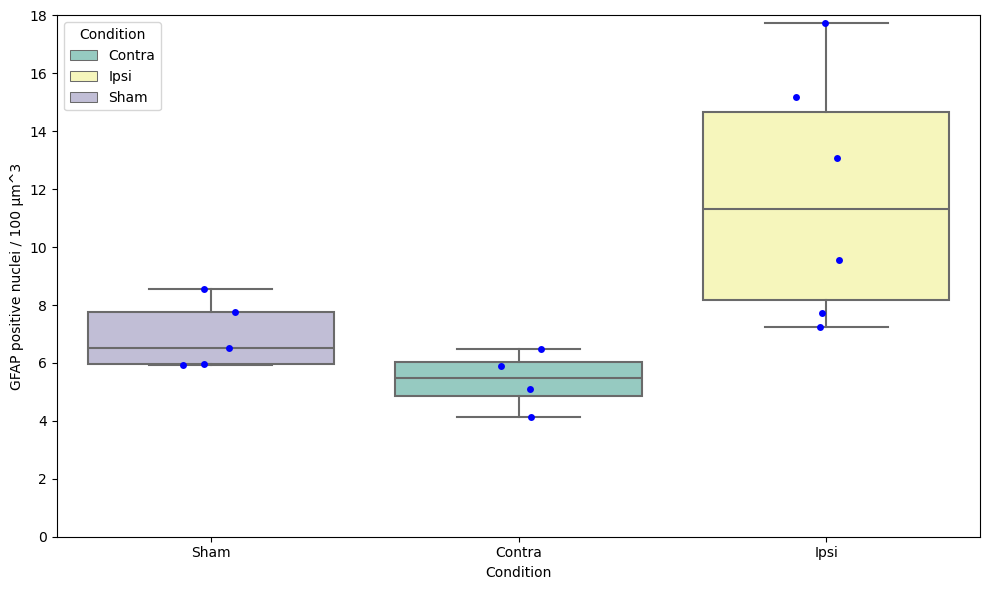

In [5]:

order = ['Sham', 'Contra', 'Ipsi']
plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.boxplot(data=merged_df, x='Condition', y='positiveVolume', showfliers=False, order=order, hue='Condition', palette='Set3', dodge=False)
sns.stripplot(data=merged_df, x='Condition', y='positiveVolume', order=order, color='Blue', dodge=False)
plt.xlabel('Condition')
plt.ylabel('GFAP positive nuclei / 100 \u03bcm^3')
plt.legend(title='Condition')
plt.ylim(0,18)
plt.tight_layout()
#plt.savefig("plots/GFAPPositive.pdf")
plt.show()

In [6]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(grouped_df.keys())

anova_results = f_oneway(merged_df[merged_df['Condition'] == 'Contra']['positiveVolume'],
                         merged_df[merged_df['Condition'] == 'Ipsi']['positiveVolume'],
                         merged_df[merged_df['Condition'] == 'Sham']['positiveVolume'])

# Perform Tukey HSD post hoc test
tukey_results = pairwise_tukeyhsd(merged_df['positiveVolume'], merged_df['Condition'])

print("ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

print("\nTukey HSD Results:")
print(tukey_results)



Index(['ImageName', 'Condition', 'DG', 'Undefined'], dtype='object', name='Location')
ANOVA Results:
F-statistic: 6.910715287030574
p-value: 0.010074086567697793

Tukey HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
Contra   Ipsi   6.3604 0.0129  1.4097 11.3111   True
Contra   Sham   1.5488 0.7082 -3.5961  6.6937  False
  Ipsi   Sham  -4.8116 0.0422 -9.4557 -0.1674   True
----------------------------------------------------


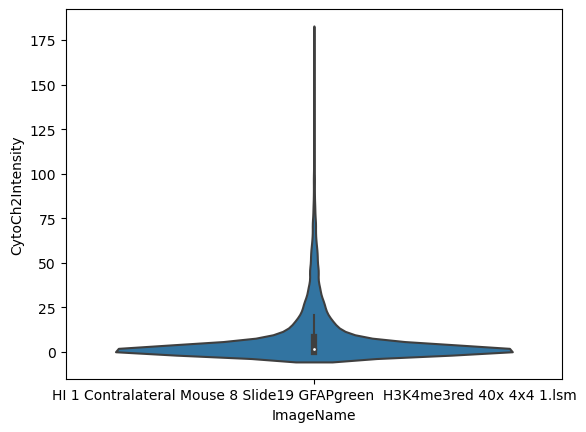

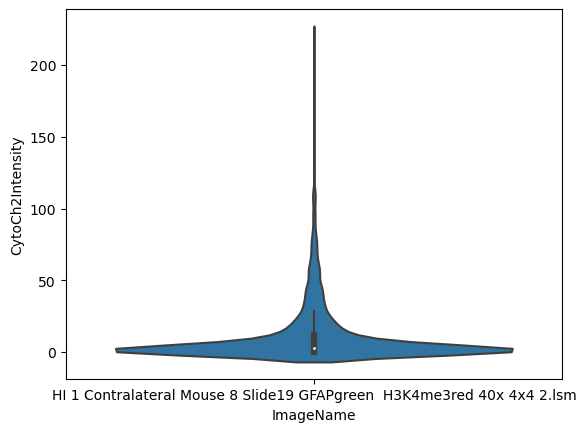

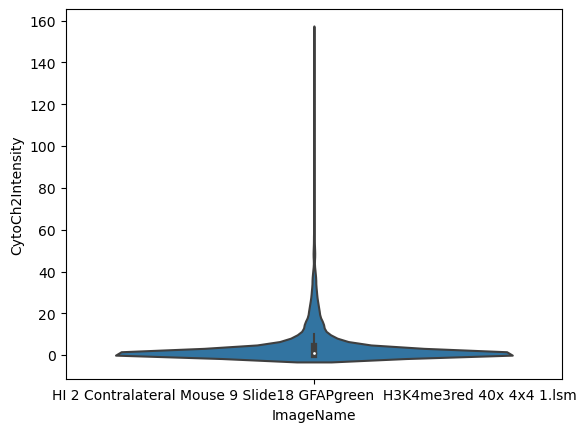

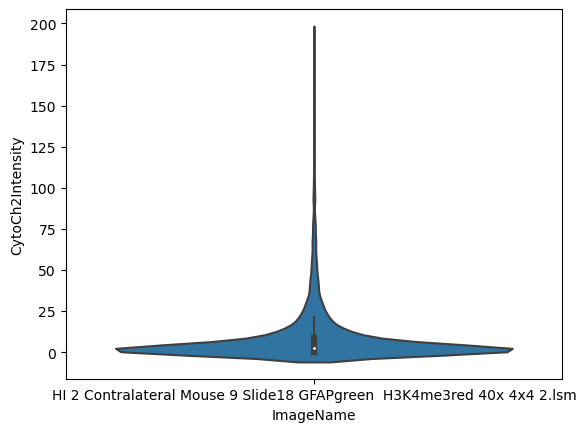

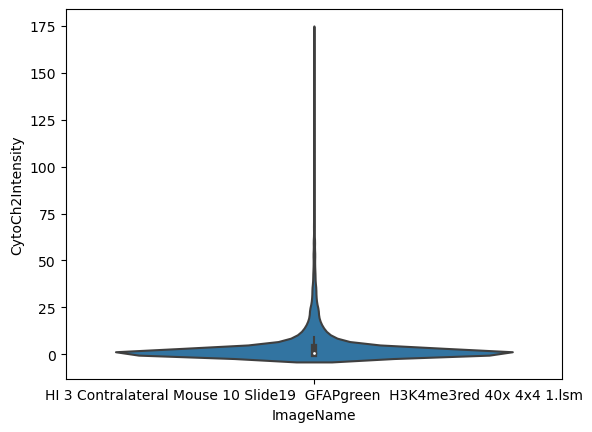

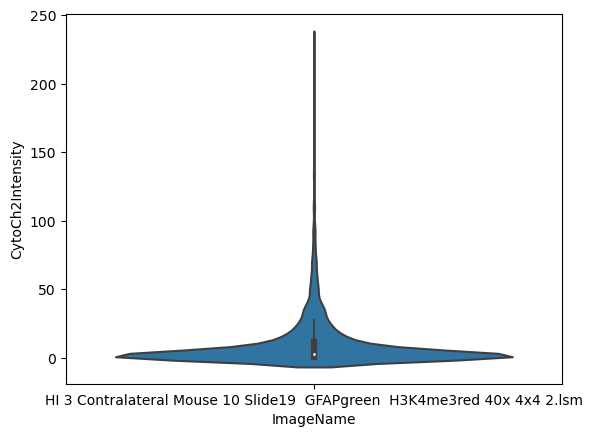

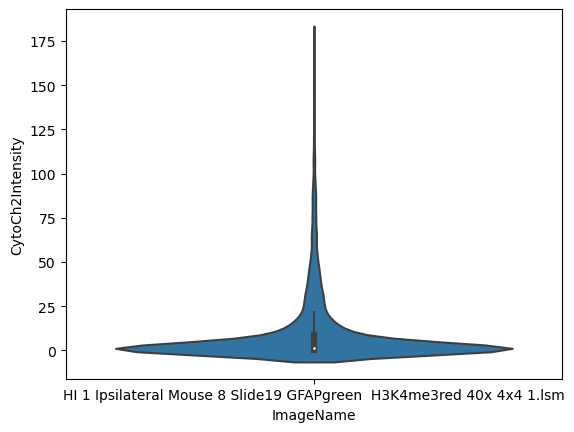

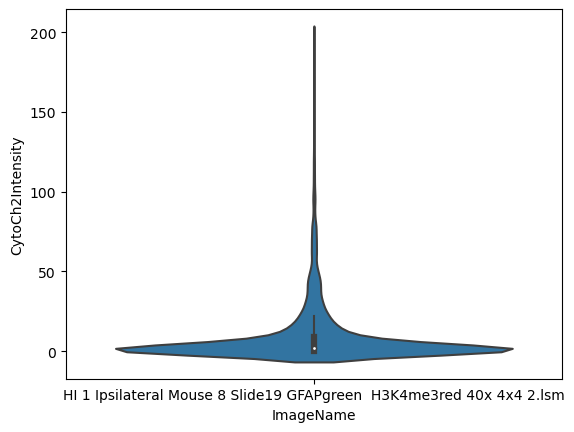

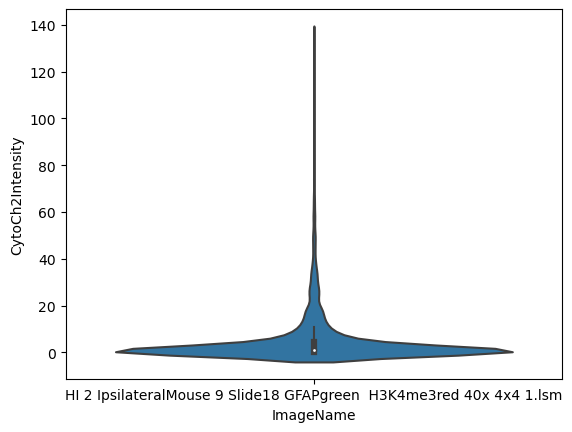

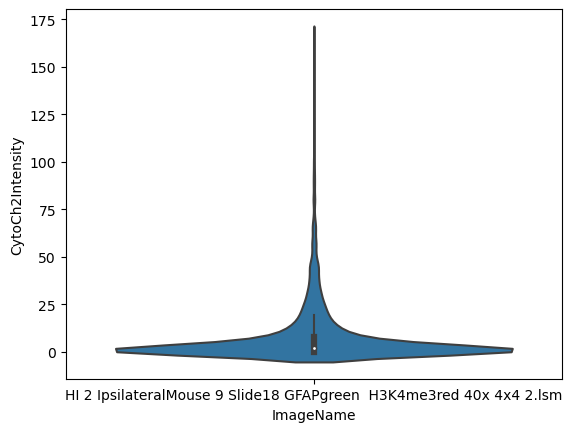

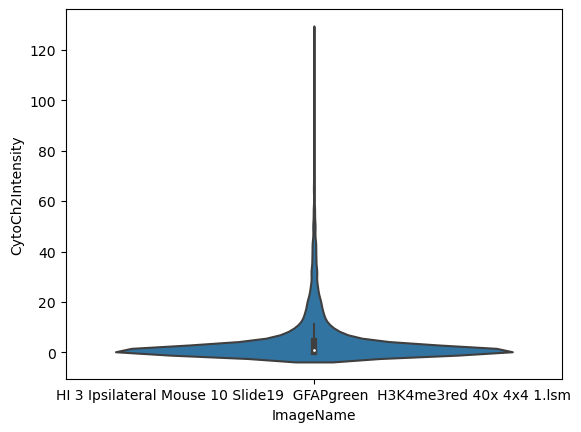

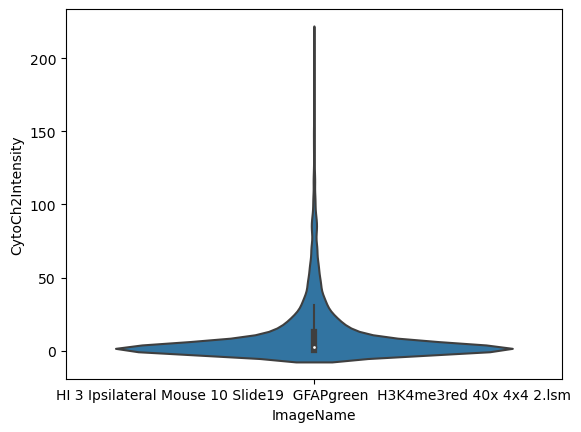

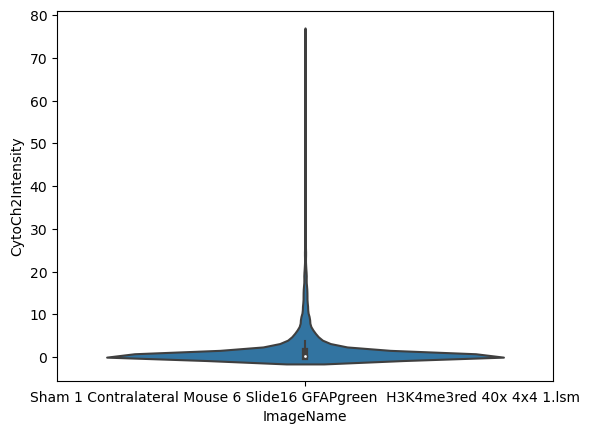

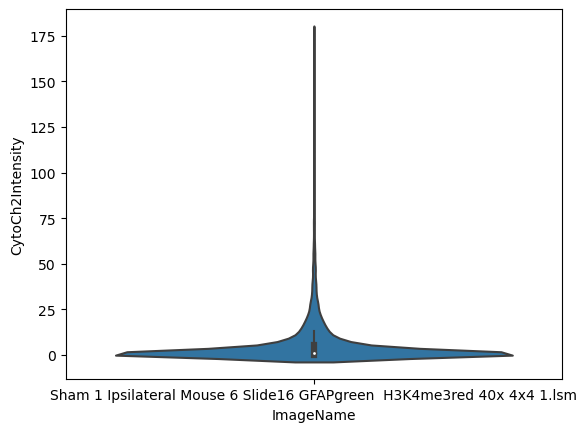

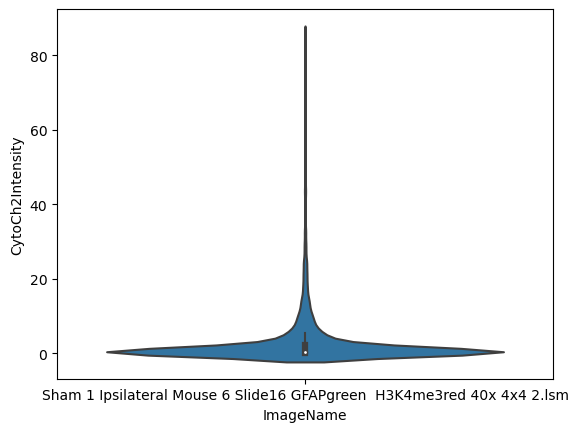

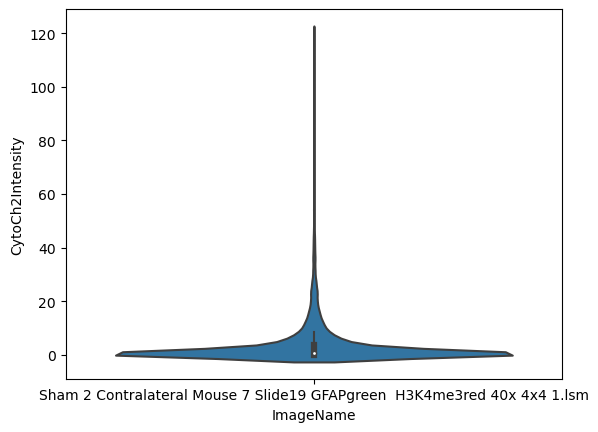

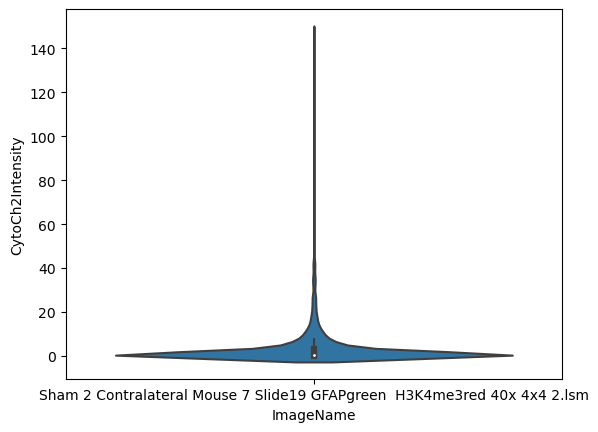

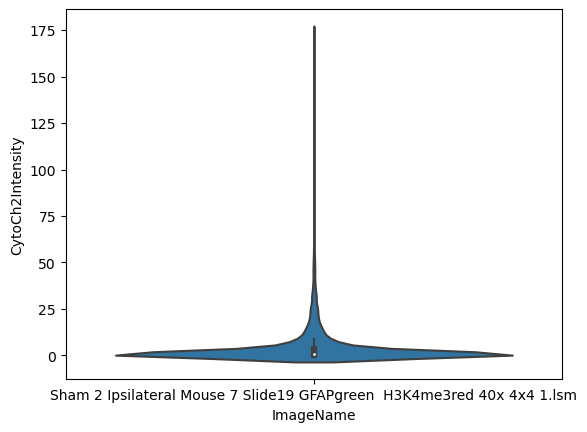

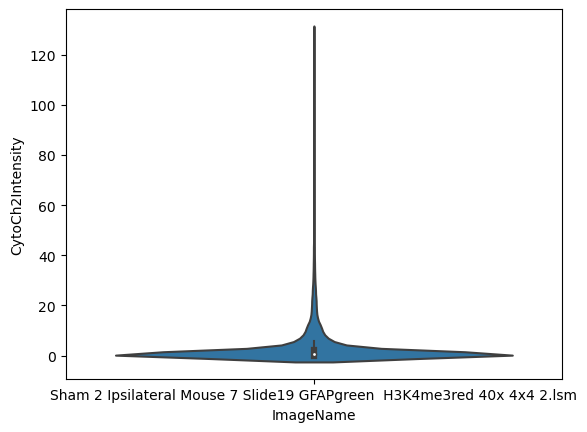

In [30]:
for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    sns.violinplot(data=df, x='ImageName', y='CytoCh2Intensity')
    plt.show()